In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
from cellpose import plot
import os
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd
import glob
import pathlib
import seaborn as sns
from pip._internal.cli.progress_bars import get_download_progress_renderer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def pad_array_with_nans(arr, mid_idx, padd_arr_len=41):
    """
    Pads an array with NaN values around "start_idx" and "end_idx" index
    """
    start_idx = max(padd_arr_len//2 - mid_idx, 0)
    # if left side doesn't fit cut and shift mid_idx
    if mid_idx >= padd_arr_len//2: 
        left_shift = mid_idx - padd_arr_len//2
        arr = arr[left_shift:]
        mid_idx = mid_idx - left_shift

    end_idx = min(padd_arr_len//2 + (len(arr) - mid_idx), padd_arr_len)
    if end_idx == padd_arr_len:
        arr = arr[:padd_arr_len-start_idx]
    
    padded_arr = np.full(padd_arr_len, np.nan)
    padded_arr[start_idx:end_idx] = arr
    return padded_arr

import numpy as np

def arrays_average_std(arrays):
    """
    Calculates average and standard deviation of multiple equally sized numpy arrays with NaNs using a loop.

    Parameters:
    arrays (list): List of numpy arrays.

    Returns:
    result (tuple): Tuple of average and standard deviation arrays for each index, with NaNs where these statistics cannot be calculated.
    """
    # Replace NaNs with zeros temporarily to calculate sum and count
    sums = np.nan_to_num(arrays[0])
    counts = np.array(~np.isnan(arrays[0]), dtype=int)
    for i in range(1, len(arrays)):
        sums += np.nan_to_num(arrays[i])
        counts += np.array(~np.isnan(arrays[i]), dtype=int)

    # Calculate average and std of each element
    result_avg = np.empty([arrays[0].size])
    result_std = np.empty([arrays[0].size])
    for i in range(arrays[0].size):
        # Calculate average and std if all elements are not NaN, otherwise set them to NaN
        if np.all(np.isnan([arr[i] for arr in arrays])):
            result_avg[i] = np.nan
            result_std[i] = np.nan
        else:
            temp_sum = np.sum([np.nan_to_num(arr[i]) for arr in arrays])
            temp_count = np.sum(~np.isnan([arr[i] for arr in arrays]))
            avg = temp_sum / temp_count
            std = np.sqrt(np.sum([(np.nan_to_num(arr[i]) - avg) ** 2 for arr in arrays if not np.isnan(arr[i])]) / (temp_count - 1))
            result_avg[i] = avg
            result_std[i] = std

    return result_avg, result_std

def arrays_average_sem(arrays):
    '''Parameters:
    arrays (list): List of numpy arrays.

    Returns:
    result (tuple): Tuple of average and standard error of the mean arrays for each index, with NaNs where these statistics cannot be calculated.
    '''
    # Replace NaNs with zeros temporarily to calculate sum and count
    sums = np.nan_to_num(arrays[0])
    counts = np.array(~np.isnan(arrays[0]), dtype=int)
    for i in range(1, len(arrays)):
        sums += np.nan_to_num(arrays[i])
        counts += np.array(~np.isnan(arrays[i]), dtype=int)

    # Calculate average and SEM of each element
    result_avg = np.empty([arrays[0].size])
    result_sem = np.empty([arrays[0].size])
    for i in range(arrays[0].size):
        # Calculate average and SEM if all elements are not NaN, otherwise set them to NaN
        if np.all(np.isnan([arr[i] for arr in arrays])):
            result_avg[i] = np.nan
            result_sem[i] = np.nan
        else:
            temp_sum = np.sum([np.nan_to_num(arr[i]) for arr in arrays])
            temp_count = np.sum(~np.isnan([arr[i] for arr in arrays]))
            avg = temp_sum / temp_count
            sem = np.sqrt(np.sum([(np.nan_to_num(arr[i]) - avg) ** 2 for arr in arrays if not np.isnan(arr[i])]) / (temp_count * (temp_count - 1)))
            result_avg[i] = avg
            result_sem[i] = sem

    return result_avg, result_sem

### import CSV
CSV with cell trajectrories created as follows:
- Cellpose segmentation
- TrackMate tracking of segmented images
- Random Forest rough segmentation of deviding cells
- Detection of division events with `nematics\journals\cell_divisions_cellpose_TrackMate.ipynb`

In [2]:
min_track_len = 50
track_df1 = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs.csv")
track_df1['count'] = track_df1.groupby('TRACK_ID')['TRACK_ID'].transform('count')
track_df2 = track_df1.loc[track_df1['count']>min_track_len]

calculate averge dynamics of `PARAMETER` for deviding cell

In [4]:
%matplotlib qt
tracks_all = track_df2["TRACK_ID"][track_df2['T0']==1].unique()

params = ['AREA', 'PERIMETER','SHAPE_INDEX', 'CIRCULARITY', 'RADIUS' , #'ELLIPSE_MAJOR', 'ELLIPSE_ASPECTRATIO'     
# 'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 
# 'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER',
# 'CIRCULARITY', 'SOLIDITY', 'SHAPE_INDEX', 'DIVIDING'
]
PARAM = 'ELLIPSE_MINOR'


frame2hr = 1/12
padd_arr_len = 400

data_dict = {}

plt.figure(PARAM)
fig, axs  = plt.subplots(1,len(params), num=PARAM)
axs = axs.ravel()

for ax,PARAM in zip(axs, params):
    param_arr = []
    for tid in tracks_all[:5000:10]:
        div_idx = track_df2[PARAM][track_df2["TRACK_ID"]==tid].index    
        param_val = track_df2[PARAM][div_idx].rolling(window=5).mean()
        # param_val = np.diff(param_val)
        t0 = track_df2["T0"][div_idx].values.astype(int)
        
        if not any(t0[0:3]):
            t0_val = t0
            # print(len(t0))

            mid_idx = int(np.where(t0>0)[0])
            #  collect param_val arrays for averaging
            param_arr.append(pad_array_with_nans(param_val, mid_idx, padd_arr_len=padd_arr_len))            

            # print(np.where(t0>0)[0])
            # ax.plot(np.arange(len(param_val)) - mid_idx, param_val, alpha=.03, linewidth=3, color='r')
            # ax.plot(np.arange(len(param_val)), param_val, alpha=.03, linewidth=3, color='r')
            
    # param_ave, param_std = arrays_average_std(param_arr) #standart diviation
    param_ave, param_std = arrays_average_sem(param_arr) #standart mean error

    print(PARAM, param_ave.shape)
    x = np.arange(len(param_ave))-padd_arr_len//2
    x = x * frame2hr
    ax.axvline(x=0, color='red', linestyle='--', linewidth=3, alpha=0.3)
    ax.plot(x, param_ave, alpha=.3, linewidth=3, color='b')
    ax.fill_between(x, param_ave - param_std, param_ave + param_std, color='blue', alpha=0.2)
    ax.set_xlabel("$hours$") 
    ax.set_title(PARAM)
    ax.set_xlim([-padd_arr_len//2 * frame2hr, padd_arr_len//2 * frame2hr])
    # ax.set_ylim([param_val.min(),param_val.max()])
    data_dict[PARAM] = {"_ave": param_ave, "std": param_std}

AREA (400,)
PERIMETER (400,)
SHAPE_INDEX (400,)
CIRCULARITY (400,)
RADIUS (400,)


Save to file (`save_path`)

In [ ]:
save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs_division_dynamics"+str(min_track_len)+".pkl"

In [ ]:
with open(save_path, 'wb') as f:
    pickle.dump(data_dict, f)

Load file (`save_path`) and plot all `PARAMS`

In [10]:
saved_averages = glob.glob(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Tracking\spots_100_500_wdivs_division_dynamics*.pkl")

dict_keys(['_ave', 'std'])


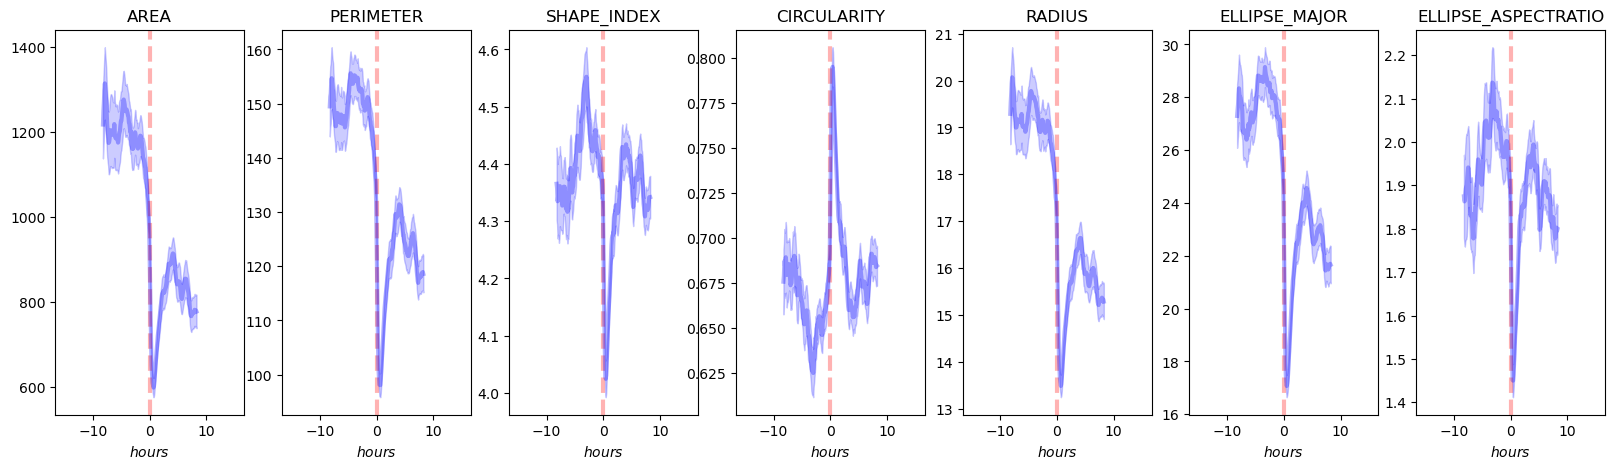

In [15]:
%matplotlib inline
save_path = saved_averages[1]
with open(save_path, 'rb') as f:
    data_dict1 = pickle.load(f)

fig, axs  = plt.subplots(1,len(data_dict1.keys()), num="1", figsize=(20, 5))
axs = axs.ravel()
print(data_dict1["AREA"].keys())

frame2hr = 1/12
for ax,param_name in zip(axs, data_dict1):
    param_ave = data_dict1[param_name]["_ave"]
    param_std = data_dict1[param_name]["std"]

    x = np.arange(len(param_ave))-len(param_ave)//2
    x = x * frame2hr
    ax.axvline(x=0, color='red', linestyle='--', linewidth=3, alpha=0.3)
    ax.plot(x, param_ave, alpha=.3, linewidth=3, color='b')
    ax.fill_between(x, param_ave - param_std, param_ave + param_std, color='blue', alpha=0.2)
    ax.set_xlabel("$hours$") 
    ax.set_title(param_name)
    ax.set_xlim([-padd_arr_len//2 * frame2hr, padd_arr_len//2 * frame2hr])

## Compare real cell boundaries with Voronoi